In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy import sparse
from scipy.interpolate import interp1d
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from scipy.sparse import csr_matrix


cwd = os.getcwd()
model_path = os.path.abspath(os.path.join(cwd, os.pardir, 'models'))
sys.path.append(model_path)
from conference_model import *

In [2]:
# Network
# Assuming 'SFHH_ConferenceNetwork.dat' is in the same directory and properly formatted
df = pd.read_csv('../data/SFHH_ConferenceNetwork.dat', delim_whitespace=True, header=None, names=['Timestamp', 'ID1', 'ID2'])

In [3]:
# Parameters
s1 = 1/3.4
p_sev = 0.45
efficacy = 0.7
g_mild = 1/2.9
g_sev = 1/5.7
R0 = 2.8
t_interv = 0
t_end_conf = 5

prop_dict = {
    "x1/day": {"Mean": 0.78, "SD": 0.14},
    "x2/day": {"Mean": 0.69, "SD": 0.15},
    "x3/day": {"Mean": 0.64, "SD": 0.15},
    "x4/day": {"Mean": 0.51, "SD": 0.20},
}

# Simulation setup
nr = 1000  # Number of realisations
Tmax = 50
dt = 0.01

In [4]:
# Initialize a dictionary to store results
results = {}

# Loop through each scenario
for scenario, values in prop_dict.items():
    prop_mean = values['Mean']
    prop_std = values['SD']
    
    # Run simulation for the treated scenario
    IsimMild_treated, IsimSev_treated, IsimTot_treated, cumul_mild_infections_treated, cumul_sev_infections_treated, cumul_infections_treated, cumul_unprotected_exposures, cumul_protected_exposures, props, N = simulate_covid_spread(nr, dt, Tmax, df, s1, p_sev, g_mild, g_sev, efficacy, t_interv, R0, prop_mean, prop_std, t_end_conf=t_end_conf, weighted='weighted', percentile=90)
    
    total_unprotected_exposures = np.asarray([inner_array[-1] for inner_array in cumul_unprotected_exposures])
    mean_unprotected_exposures = np.mean(total_unprotected_exposures)

    total_protected_exposures = np.asarray([inner_array[-1] for inner_array in cumul_protected_exposures])
    mean_protected_exposures = np.mean(total_protected_exposures)

    n_protected = props*N
    n_unprotected = (1-props)*N

    mean_n_protected = int(np.mean(n_protected))
    mean_n_unprotected = int(np.mean(n_unprotected))

    # Store results in the dictionary
    results[scenario] = {
        'Mean total unprotected': mean_n_unprotected,
        'Mean total protected': mean_n_protected,
        'Mean unprotected exposures': mean_unprotected_exposures,
        'Mean protected exposures': mean_protected_exposures
    }

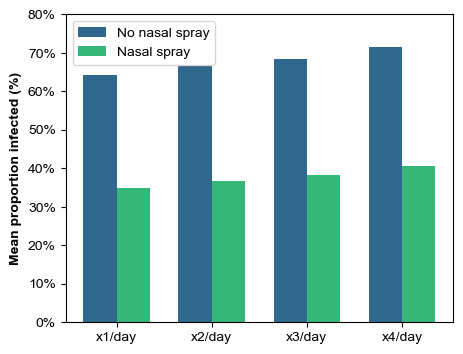

In [7]:
# Plotting section
plt.rcParams['font.family'] = 'Arial'
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Extract data for plotting
scenarios = list(results.keys())
percent_unprotected = [(results[scenario]['Mean unprotected exposures'] / results[scenario]['Mean total unprotected']) for scenario in scenarios]
percent_protected = [(results[scenario]['Mean protected exposures'] / results[scenario]['Mean total protected']) for scenario in scenarios]

# Indices for the scenarios
ind = np.arange(len(scenarios))
width = 0.35  # width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
bars_unprotected = ax.bar(ind - width/2, percent_unprotected, width, label='No nasal spray', color=colors[1])
bars_protected = ax.bar(ind + width/2, percent_protected, width, label='Nasal spray', color=colors[2])

# Add some text for labels, title and axes ticks
ax.set_ylabel('Mean proportion infected (%)', weight='bold', fontsize=10)
ax.set_xticks(ind)
ax.set_xticklabels(scenarios, fontsize=10)
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
ax.set_ylim(0, 0.8)

# Define the directory path and the filename
directory = '../figures'
filename = 'figure5.svg'

# Check if the directory exists
if not os.path.exists(directory):
    # If the directory does not exist, create it
    os.makedirs(directory)

# Save the figure
plt.savefig(os.path.join(directory, filename), bbox_inches='tight')
plt.show()